In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name='cifar100-resnet'

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar100.tgz


In [4]:
# Extract from archive
# with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whal

In [6]:
beaver_files = os.listdir(data_dir + "/train/beaver")
print('No. of training examples for beaver:', len(beaver_files))
print(beaver_files[:5])

No. of training examples for beaver: 500
['beaver_s_000001.png', 'beaver_s_000004.png', 'beaver_s_000010.png', 'beaver_s_000012.png', 'beaver_s_000013.png']


In [7]:
baby_files = os.listdir(data_dir + "/test/baby")
print("No. of test examples for baby:", len(baby_files))
print(baby_files[:5])

No. of test examples for baby: 100
['baby_s_000023.png', 'baby_s_000030.png', 'baby_s_000034.png', 'baby_s_000042.png', 'baby_s_000046.png']


In [8]:
# Data transforms (normalization & data augmentation)
stats = ([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [10]:
batch_size = 400

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [12]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

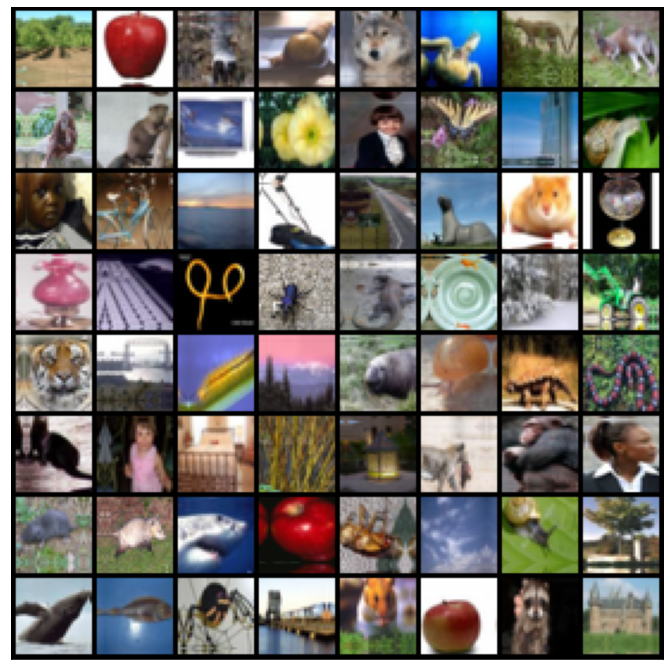

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class ResNet50(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        # Use a pretrained model
        self.network = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        # Replace last layer
#         self.network.fc1 = nn.Flatten()
#         self.network.fc2 = nn.Dropout(0.2)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [174]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#               nn.BatchNorm2d(out_channels), 
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

# class ResNet9(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
        
#         self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
#         self.conv3 = conv_block(128, 256, pool=True)
#         self.conv4 = conv_block(256, 512, pool=True)
#         self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
#         self.classifier = nn.Sequential(nn.MaxPool2d(4), 
#                                         nn.Flatten(), 
#                                         nn.Dropout(0.2),
#                                         nn.Linear(512, num_classes))
        
#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out) + out
#         out = self.classifier(out)
#         return out

In [19]:
 torch.cuda.is_available()

True

In [ ]:
train_ds.classes

In [20]:
model = to_device(ResNet50(len(train_ds.classes)), device)
model

ResNet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [21]:
torch.cuda.empty_cache()

In [22]:
from tqdm.notebook import tqdm

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.894829273223877, 'val_acc': 0.010288461111485958}]

In [25]:
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00138, train_loss: 2.8204, val_loss: 1.9286, val_acc: 0.4862


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00394, train_loss: 1.8872, val_loss: 2.4321, val_acc: 0.4031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00703, train_loss: 2.2484, val_loss: 4.9605, val_acc: 0.1232


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00935, train_loss: 2.4812, val_loss: 2.5900, val_acc: 0.3658


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00999, train_loss: 2.1702, val_loss: 2.7352, val_acc: 0.3545


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00972, train_loss: 2.0139, val_loss: 2.3753, val_acc: 0.3997


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00908, train_loss: 1.8907, val_loss: 2.1883, val_acc: 0.4262


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00812, train_loss: 1.7804, val_loss: 1.9797, val_acc: 0.4788


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00691, train_loss: 1.6490, val_loss: 1.9605, val_acc: 0.4793


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00556, train_loss: 1.5295, val_loss: 1.7902, val_acc: 0.5105


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00416, train_loss: 1.3756, val_loss: 1.6168, val_acc: 0.5556


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00283, train_loss: 1.2100, val_loss: 1.4779, val_acc: 0.5861


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00167, train_loss: 1.0163, val_loss: 1.3735, val_acc: 0.6213


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00077, train_loss: 0.8363, val_loss: 1.2767, val_acc: 0.6497


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00020, train_loss: 0.6793, val_loss: 1.2358, val_acc: 0.6591


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00000, train_loss: 0.6151, val_loss: 1.2313, val_acc: 0.6589
CPU times: total: 4min 23s
Wall time: 11min 27s


In [27]:
train_time='11:27'

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

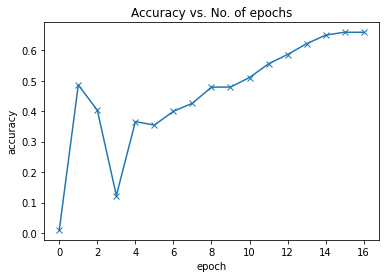

In [29]:
plot_accuracies(history)

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

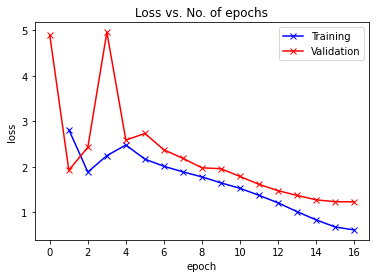

In [31]:
plot_losses(history)

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

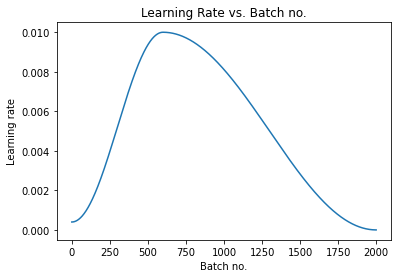

In [33]:
plot_lrs(history)

In [34]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: apple , Predicted: apple


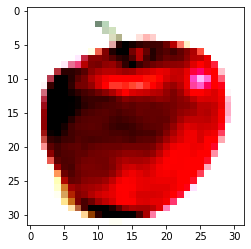

In [35]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bowl , Predicted: bowl


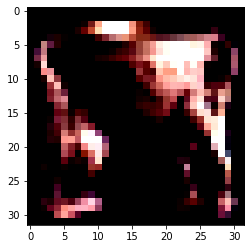

In [36]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plate , Predicted: plate


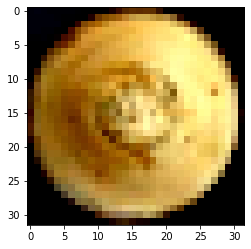

In [37]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [38]:
torch.save(model.state_dict(), 'cifar100-resnet50.pth')

In [39]:
!pip install jovian --upgrade --quiet

In [40]:
import jovian

In [41]:
jovian.reset()
jovian.log_hyperparams(arch='resnet50',
                       weights = 'pretrained-CIFAR100',
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [42]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [43]:
jovian.commit(project=project_name, environment=None, outputs=['cifar100-resnet50.pth'])

<IPython.core.display.Javascript object>

[jovian] Updating notebook "gopirevathisreenivasan/cifar100-resnet" on https://jovian.ai/
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/gopirevathisreenivasan/cifar100-resnet


'https://jovian.ai/gopirevathisreenivasan/cifar100-resnet'